In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from tqdm import tqdm
from sklearn.utils import shuffle

class Linear():
    def __init__(self, in_features, out_features, act=None, act_bkwd=None):
      self.W=np.random.randn(in_features,out_features)*np.sqrt(2/out_features)
      self.b=np.zeros(out_features)
      self.activation=act
      self.activation_bkwd=act_bkwd
    
    def __call__(self, x, *args, **kwargs):
        return x@self.W+self.b

class NumpyMLP():
  def __init__(self, train_file, test_file, activation='relu'):
    #PART a
    self.data={}
    self.act=activation
    with h5py.File(train_file, 'r') as hf:
        self.data['x_train']=hf['xdata'][:]
        self.data['x_valid']=self.data['x_train'][50000:]
        self.data['x_train']=self.data['x_train'][:50000]
        self.data['y_train']=hf['ydata'][:]
        self.data['y_valid']=self.data['y_train'][50000:]
        self.data['y_train']=self.data['y_train'][:50000]
    with h5py.File(test_file,'r') as hf:
        self.data['x_test']=hf['xdata'][:]
        self.data['y_test']=hf['ydata'][:]
    print('Train set shapes:', self.data['x_train'].shape,self.data['y_train'].shape)
    print('Valid set shapes:', self.data['x_valid'].shape, self.data['y_valid'].shape)
    print('Test set shapes:',self.data['x_test'].shape, self.data['y_test'].shape)
    
    #PART b & c 
    if activation=='relu':
      self.linear1=Linear(in_features=784, out_features=512, act=self.relu, act_bkwd=self.relu_backward)
      self.linear2=Linear(in_features=512,out_features=64, act=self.relu, act_bkwd=self.relu_backward)
      self.linear3=Linear(in_features=64, out_features=32, act=self.relu, act_bkwd=self.relu_backward)
      self.linear4=Linear(in_features=32, out_features=10)
    else:
      self.linear1=Linear(in_features=784, out_features=512, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear2=Linear(in_features=512,out_features=64, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear3=Linear(in_features=64, out_features=32, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear4=Linear(in_features=32, out_features=10)
  
  def relu(self, x):
    return np.clip(x,a_min=0,a_max=None)

  def relu_backward(self,x):
    x[x<=0]=0
    x[x>0]=1
    return x

  def tanh(self,x):
    return np.tanh(x)

  def tanh_backward(self, x):
    out = [1-np.tanh(sample)**2 for sample in x]
    return np.array(out)

  def softmax(self, x):
    out=[np.exp(sample)/np.sum(np.exp(sample)) for sample in x]
    return np.array(out)

  def save_weights(self, model_path):
    with h5py.File(model_path, 'w') as hf:
      hf.create_dataset('linear_1.weight', data=self.linear1.W)
      hf.create_dataset('linear_1.bias', data=self.linear1.b)
      hf.create_dataset('linear_2.weight', data=self.linear2.W)
      hf.create_dataset('linear_2.bias', data=self.linear2.b)
      hf.create_dataset('linear_3.weight', data=self.linear3.W)
      hf.create_dataset('linear_3.bias', data=self.linear3.b)
      hf.create_dataset('linear_4.weight', data=self.linear4.W)
      hf.create_dataset('linear_4.bias', data=self.linear4.b)
      hf.create_dataset('activation',data=self.act)

  def load_weights(self,model_path):
    with h5py.File(model_path,'r') as hf:
      self.linear1.W=hf['linear_1.weight'][:]
      self.linear1.b=hf['linear_1.bias'][:]
      self.linear2.W=hf['linear_2.weight'][:]
      self.linear2.b=hf['linear_2.bias'][:]
      self.linear3.W=hf['linear_3.weight'][:]
      self.linear3.b=hf['linear_3.bias'][:]
      self.linear4.W=hf['linear_4.weight'][:]
      self.linear4.b=hf['linear_4.bias'][:]
      if hf['activation']=='relu':
        self.linear1.activation, self.linear1.activation_bkwd=self.relu, self.relu_backward
        self.linear2.activation, self.linear2.activation_bkwd=self.relu, self.relu_backward
        self.linear3.activation, self.linear3.activation_bkwd=self.relu, self.relu_backward
        self.linear4.activation, self.linear4.activation_bkwd=self.relu, self.relu_backward
      else:
        self.linear1.activation, self.linear1.activation_bkwd=self.tanh, self.tanh_backward
        self.linear2.activation, self.linear2.activation_bkwd=self.tanh, self.tanh_backward
        self.linear3.activation, self.linear3.activation_bkwd=self.tanh, self.tanh_backward
        self.linear4.activation, self.linear4.activation_bkwd=self.tanh, self.tanh_backward
         
  def final_train_test(self, epochs, batch_size=50, lr=1e-3, save_path='model.hdf5'):
    losses=[]
    train_losses=[]
    valid_losses=[]
    train_accuracy=[]
    valid_accuracy=[]
    steps=[]
    best_val_acc=0.0
    full_x_data=np.vstack((mlp.data['x_train'], mlp.data['x_valid']))
    full_y_data=np.vstack((mlp.data['y_train'], mlp.data['y_valid']))
    full_x_data, full_y_data = shuffle(full_x_data,full_y_data)
    for i in tqdm(range(epochs)):
      if i == int(epochs*0.5):
        lr=lr/2
      if i == int(epochs*0.78):
        lr=lr/2
      steps.append(lr)
      running_loss=0.0
      count=0
      for j in range(0, full_x_data.shape[0], batch_size):
        x_batch=full_x_data[j:j+batch_size]
        x_batch=x_batch/255.
        noise=np.random.normal(0,0.05,x_batch.shape)
        x_batch=x_batch+noise
        y_batch=full_y_data[j:j+batch_size]
        
        h_1=self.linear1(x_batch)
        a_1=self.linear1.activation(h_1)
        noise=np.random.normal(0,0.05,a_1.shape)
        a_1+=noise
        h_2=self.linear2(a_1)
        a_2=self.linear2.activation(h_2)
        noise=np.random.normal(0,0.05,a_2.shape)
        a_2+=noise
        h_3=self.linear3(a_2)
        a_3=self.linear3.activation(h_3)
        noise=np.random.normal(0,0.05,a_3.shape)
        # a_3+=noise
        h_4=self.linear4(a_3)
        a_4=self.softmax(h_4)

        loss=-np.sum(y_batch*np.log(a_4))/y_batch.shape[0]
        running_loss+=loss
        count+=batch_size
        
        delta_L = (a_4-y_batch)/x_batch.shape[0]
        da_3 = self.linear3.activation_bkwd(h_3)
        da_2 = self.linear2.activation_bkwd(h_2)
        da_1 = self.linear1.activation_bkwd(h_1)
        
        delta_3 = np.multiply(da_3, delta_L@self.linear4.W.T)
        delta_2 = np.multiply(da_2,delta_3@self.linear3.W.T)
        delta_1 = np.multiply(da_1,delta_2@self.linear2.W.T)

        # print(np.multiply(delta_L, a_3).shape)
        # print(a_3.shape, y_batch.shape, delta_L.shape, a_3.shape, self.linear3.W.shape, a_2.shape, a_1.shape, delta_2.shape, self.linear2.W.shape)
        self.linear4.W = self.linear4.W - lr* (a_3.T@delta_L)/x_batch.shape[0]
        self.linear4.b = self.linear4.b - lr* np.average(delta_L, axis=0)

        self.linear3.W = self.linear3.W - lr * (a_2.T@delta_3)/x_batch.shape[0]
        self.linear3.b = self.linear3.b - lr * np.average(delta_3,axis=0)

        self.linear2.W = self.linear2.W - lr * (a_1.T@delta_2)/x_batch.shape[0]
        self.linear2.b = self.linear2.b - lr* np.average(delta_2,axis=0)

        self.linear1.W = self.linear1.W - lr * (x_batch.T@delta_1)/x_batch.shape[0]
        self.linear1.b = self.linear1.b - lr * np.average(delta_1,axis=0)
                
      losses.append(running_loss/count)
      y_pred_train=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(full_x_data/255.))))))))
      y_pred_logits=np.argmax(y_pred_train,axis=1)
      y_gt_logits=np.argmax(full_y_data,axis=1)
      train_accuracy.append((y_pred_logits==y_gt_logits).sum()/y_gt_logits.shape[0])
      train_losses.append(-np.sum(full_y_data*np.log(y_pred_train))/y_pred_train.shape[0])
    y_pred_test=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(self.data['x_test']/255.))))))))      
    y_pred_test_logits=np.argmax(y_pred_test,axis=1)
    y_gt_test_logits=np.argmax(self.data['y_test'],axis=1)
    print('Final test accuracy:',(y_pred_test_logits==y_gt_test_logits).sum()/y_gt_test_logits.shape[0])
    return losses, train_losses, valid_losses, train_accuracy, valid_accuracy, steps


  def train(self, epochs, batch_size=50, lr=1e-3, save_path='model.hdf5'):
    losses=[]
    train_losses=[]
    valid_losses=[]
    train_accuracy=[]
    valid_accuracy=[]
    steps=[]
    best_val_acc=0.0
    for i in tqdm(range(epochs)):
      if i == int(epochs*0.5):
        lr=lr/2
      if i == int(epochs*0.78):
        lr=lr/2
      steps.append(lr)
      running_loss=0.0
      count=0
      for j in range(0, self.data['x_train'].shape[0], batch_size):
        x_batch=self.data['x_train'][j:j+batch_size]
        x_batch=x_batch/255.
        noise=np.random.normal(0,0.05,x_batch.shape)
        x_batch=x_batch+noise
        y_batch=self.data['y_train'][j:j+batch_size]
        
        h_1=self.linear1(x_batch)
        a_1=self.linear1.activation(h_1)
        noise=np.random.normal(0,0.05,a_1.shape)
        a_1+=noise
        h_2=self.linear2(a_1)
        a_2=self.linear2.activation(h_2)
        noise=np.random.normal(0,0.05,a_2.shape)
        a_2+=noise
        h_3=self.linear3(a_2)
        a_3=self.linear3.activation(h_3)
        noise=np.random.normal(0,0.05,a_3.shape)
        # a_3+=noise
        h_4=self.linear4(a_3)
        a_4=self.softmax(h_4)

        loss=-np.sum(y_batch*np.log(a_4))/y_batch.shape[0]
        running_loss+=loss
        count+=batch_size
        
        delta_L = (a_4-y_batch)/x_batch.shape[0]
        da_3 = self.linear3.activation_bkwd(h_3)
        da_2 = self.linear2.activation_bkwd(h_2)
        da_1 = self.linear1.activation_bkwd(h_1)
        
        delta_3 = np.multiply(da_3, delta_L@self.linear4.W.T)
        delta_2 = np.multiply(da_2,delta_3@self.linear3.W.T)
        delta_1 = np.multiply(da_1,delta_2@self.linear2.W.T)

        # print(np.multiply(delta_L, a_3).shape)
        # print(a_3.shape, y_batch.shape, delta_L.shape, a_3.shape, self.linear3.W.shape, a_2.shape, a_1.shape, delta_2.shape, self.linear2.W.shape)
        self.linear4.W = self.linear4.W - lr* (a_3.T@delta_L)/x_batch.shape[0]
        self.linear4.b = self.linear4.b - lr* np.average(delta_L, axis=0)

        self.linear3.W = self.linear3.W - lr * (a_2.T@delta_3)/x_batch.shape[0]
        self.linear3.b = self.linear3.b - lr * np.average(delta_3,axis=0)

        self.linear2.W = self.linear2.W - lr * (a_1.T@delta_2)/x_batch.shape[0]
        self.linear2.b = self.linear2.b - lr* np.average(delta_2,axis=0)

        self.linear1.W = self.linear1.W - lr * (x_batch.T@delta_1)/x_batch.shape[0]
        self.linear1.b = self.linear1.b - lr * np.average(delta_1,axis=0)
                
      losses.append(running_loss/count)
      y_pred_train=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(self.data['x_train']/255.))))))))
      y_pred_logits=np.argmax(y_pred_train,axis=1)
      y_gt_logits=np.argmax(self.data['y_train'],axis=1)
      train_accuracy.append((y_pred_logits==y_gt_logits).sum()/y_gt_logits.shape[0])
      train_losses.append(-np.sum(self.data['y_train']*np.log(y_pred_train))/y_pred_train.shape[0])
      y_pred_valid=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(self.data['x_valid']/255.))))))))      
      y_pred_valid_logits=np.argmax(y_pred_valid,axis=1)
      y_gt_valid_logits=np.argmax(self.data['y_valid'],axis=1)
      valid_losses.append(-np.sum(self.data['y_valid']*np.log(y_pred_valid))/y_pred_valid.shape[0])
      valid_accuracy.append((y_pred_valid_logits==y_gt_valid_logits).sum()/y_gt_valid_logits.shape[0])
      if valid_accuracy[-1]>best_val_acc:
        best_val_acc=valid_accuracy[-1]
        self.save_weights(save_path)
    return losses, train_losses, valid_losses, train_accuracy, valid_accuracy, steps



In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='relu')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=5e-2, save_path='model_relu_5e-2.hdf5')
valid_accuracy[-1]









  0%|          | 0/50 [00:00<?, ?it/s]

Train set shapes: (50000, 784) (50000, 10)
Valid set shapes: (10000, 784) (10000, 10)
Test set shapes: (10000, 784) (10000, 10)










  2%|▏         | 1/50 [00:17<14:18, 17.51s/it]







  4%|▍         | 2/50 [00:34<13:50, 17.29s/it]







  6%|▌         | 3/50 [00:51<13:26, 17.17s/it]







  8%|▊         | 4/50 [01:07<13:02, 17.02s/it]







 10%|█         | 5/50 [01:24<12:42, 16.95s/it]







 12%|█▏        | 6/50 [01:41<12:25, 16.94s/it]







 14%|█▍        | 7/50 [01:58<12:05, 16.88s/it]







 16%|█▌        | 8/50 [02:15<11:47, 16.85s/it]







 18%|█▊        | 9/50 [02:32<11:33, 16.92s/it]







 20%|██        | 10/50 [02:48<11:14, 16.85s/it]







 22%|██▏       | 11/50 [03:05<10:59, 16.92s/it]







 24%|██▍       | 12/50 [03:22<10:44, 16.95s/it]







 26%|██▌       | 13/50 [03:39<10:24, 16.89s/it]







 28%|██▊       | 14/50 [03:56<10:07, 16.88s/it]







 30%|███       | 15/50 [04:13<09:51, 16.91s/it]







 32%|███▏      | 16/50 [04:30<09:33, 16.88s/it]







 34%|███▍      | 17/50 [04:47<09:17, 16.89s/it]







 36%|███▌      | 18/50 [05:04<09:00, 16.90s/it]







 38%|███▊  

0.9573

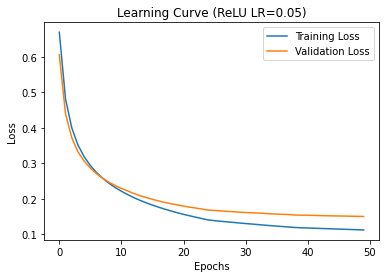

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Learning Curve (ReLU LR=0.05)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

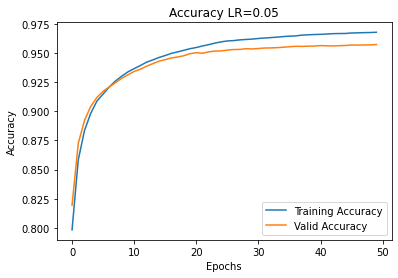

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.title('Accuracy LR=0.05')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

No handles with labels found to put in legend.


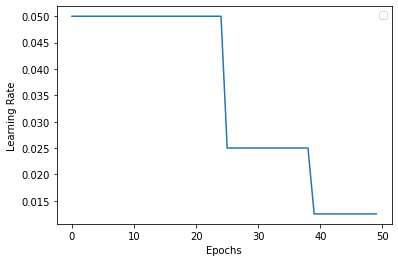

{0.05, 0.0125, 0.025}


In [ ]:
plt.plot(lr_steps)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()
print(set(lr_steps))

In [ ]:
model_relu_lr5e2=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]

In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='relu')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=1e-2, save_path='model_relu_1e-2.hdf5')
valid_accuracy[-1]

In [ ]:
model_relu_lr1e2=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]

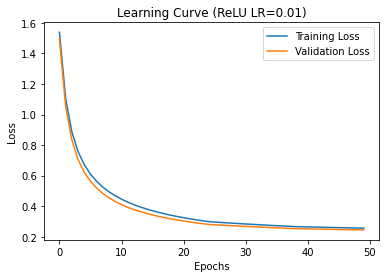

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Learning Curve (ReLU LR=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

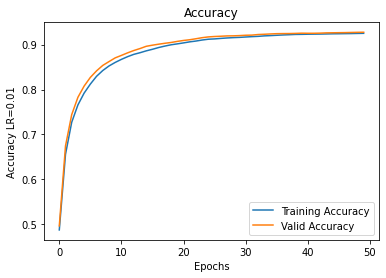

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy LR=0.01')
plt.legend()
plt.show()

In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='relu')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=1e-1, save_path='model_relu_1e-3.hdf5')
model_relu_lr1e1=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]
valid_accuracy[-1]

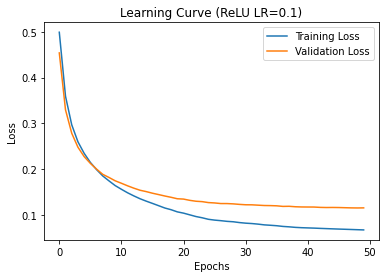

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Learning Curve (ReLU LR=0.1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

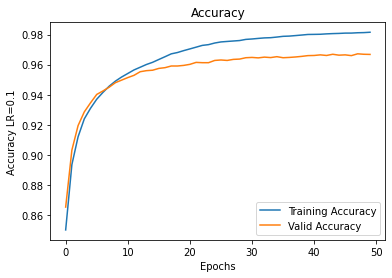

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy LR=0.1')
plt.legend()
plt.show()

In [ ]:
model_relu_lr1e1=model_relu_lr1e3

In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='tanh')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=5e-2, save_path='model_tanh_5e-2.hdf5')
valid_accuracy[-1]

In [ ]:
model_tanh_lr5e2=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]

In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='tanh')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=1e-1, save_path='model_tanh_1e-1.hdf5')
valid_accuracy[-1]

In [ ]:
model_tanh_lr1e1=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]

In [ ]:
print(model_relu_lr1e1[-2][-1])
print(model_relu_lr1e2[-2][-1])
print(model_relu_lr5e2[-2][-1])
print(model_tanh_lr1e1[-2][-1])
print(model_tanh_lr5e2[-2][-1])

0.9668
0.9276
0.9573
0.9599
0.9494


In [ ]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='relu')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.final_train_test(epochs=50, lr=1e-1)









  0%|          | 0/50 [00:00<?, ?it/s]

Train set shapes: (50000, 784) (50000, 10)
Valid set shapes: (10000, 784) (10000, 10)
Test set shapes: (10000, 784) (10000, 10)










  2%|▏         | 1/50 [00:19<15:56, 19.52s/it]







  4%|▍         | 2/50 [00:38<15:34, 19.48s/it]







  6%|▌         | 3/50 [00:58<15:13, 19.44s/it]







  8%|▊         | 4/50 [01:17<14:51, 19.37s/it]







 10%|█         | 5/50 [01:36<14:31, 19.36s/it]







 12%|█▏        | 6/50 [01:56<14:13, 19.41s/it]







 14%|█▍        | 7/50 [02:15<13:52, 19.37s/it]







 16%|█▌        | 8/50 [02:35<13:38, 19.49s/it]







 18%|█▊        | 9/50 [02:54<13:18, 19.48s/it]







 20%|██        | 10/50 [03:14<12:59, 19.49s/it]







 22%|██▏       | 11/50 [03:38<13:33, 20.86s/it]







 24%|██▍       | 12/50 [03:58<13:01, 20.56s/it]







 26%|██▌       | 13/50 [04:19<12:44, 20.65s/it]







 28%|██▊       | 14/50 [04:39<12:23, 20.64s/it]







 30%|███       | 15/50 [05:00<12:08, 20.81s/it]







 32%|███▏      | 16/50 [05:24<12:11, 21.51s/it]







 34%|███▍      | 17/50 [05:45<11:47, 21.43s/it]







 36%|███▌      | 18/50 [06:07<11:29, 21.55s/it]







 38%|███▊  

Final test accuracy: 0.9673


Final test accuracy: 0.9673 ! Yay! with ReLU and 0.1 LR 

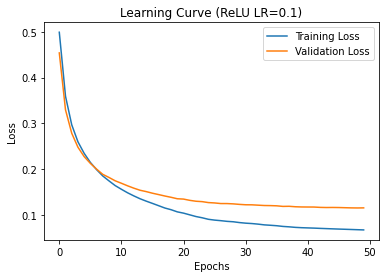

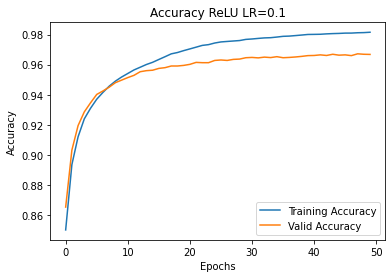

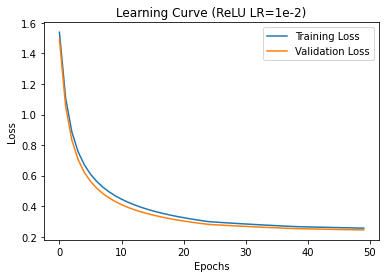

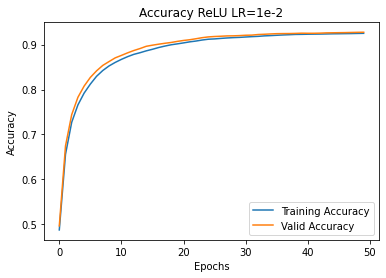

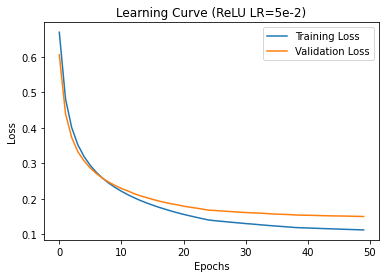

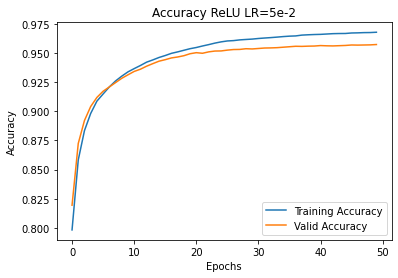

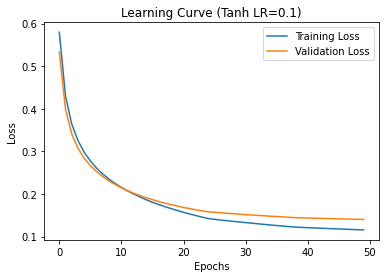

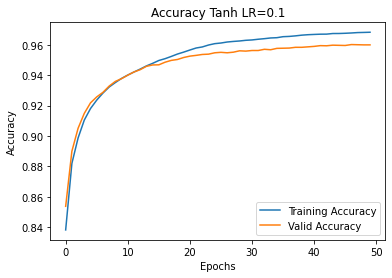

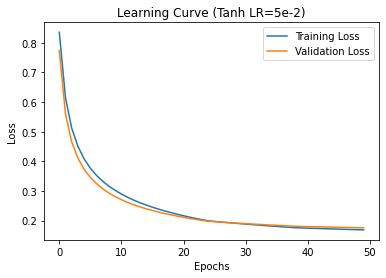

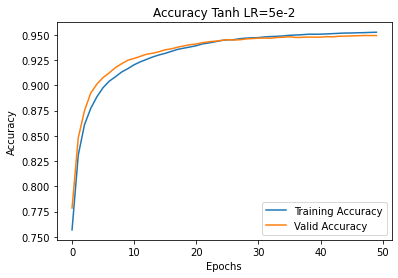

In [92]:
settings=['ReLU LR=0.1','ReLU LR=1e-2','ReLU LR=5e-2','Tanh LR=0.1', 'Tanh LR=5e-2']
for i,model in enumerate([model_relu_lr1e1,model_relu_lr1e2,model_relu_lr5e2,model_tanh_lr1e1,model_tanh_lr5e2]):
  losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps = model 
  plt.plot(train_losses, label='Training Loss')
  plt.plot(valid_losses, label='Validation Loss')
  plt.title('Learning Curve ('+settings[i]+')')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.figure()
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(valid_accuracy, label='Valid Accuracy')
  plt.title('Accuracy '+settings[i])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()